
# TEST DU PROGRAMME SANS MODIFICATIONS DES PARAMETRES :

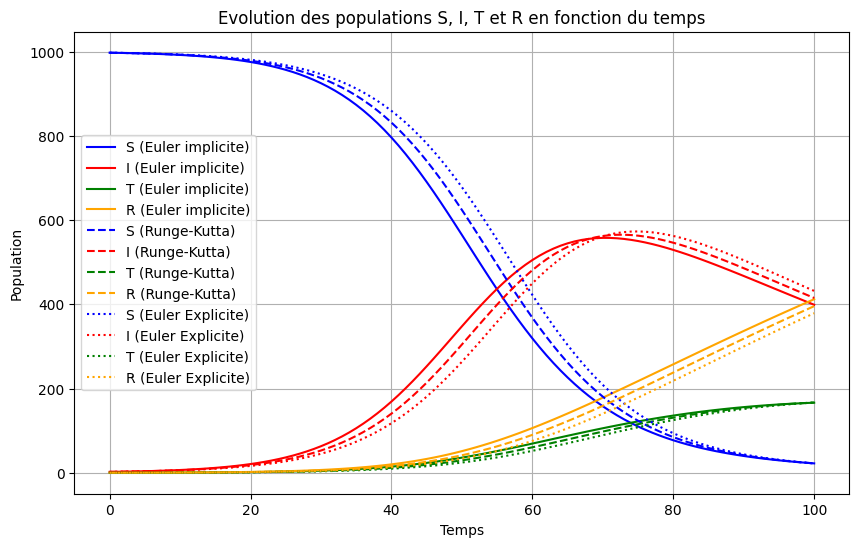

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as widgets
from ipywidgets import interact, Layout
import copy as copy


# Définition des paramètres
N = 1000.0  # Population totale
beta = 1.3  # Taux de transmission
alpha = 0.1  # Taux de guérison
gamma = 0.1  # Taux de mortalité
eta = 0.2  # Taux de transition de T vers R
delta = 0.2  # Paramètre supplémentaire

# Conditions initiales
S0 = 1000.0 - 2
I0 = 2.0
T0 = 0
R0 = 0

# Pas de temps et nombre d'itérations
dt = 0.1
iterations = 100



# Fonction décrivant les équations différentielles du système SIR
def equations_SIR(S, I, T, R):
    dS = -beta / N * (I + delta * T) * S
    dI = beta / N * (S * (I + delta * T)) - (alpha + gamma) * I
    dT = alpha * I - eta * T
    dR = gamma * I + eta * T
    return dS, dI, dT, dR

#Defintion de la Fonction
def f(x,y,z,w,x0):
    a=x0[0]
    b=x0[1]
    c=x0[2]
    d=x0[3]
    
    dS = x + beta * dt * (y + delta * z) * x / N - a
    dI = y - b - dt * (beta / N * (x* (y + delta * z)) - (alpha + gamma) * y)
    dR = z - dt * (alpha * y - eta * z) - c
    dT = w - d - dt * (gamma * y + eta * z)
    
    return np.array([dS, dI, dR, dT])

#Defintion de la Jacobienne de f
def Df(x,y,z,w):
    
    f1x1 = 1 + beta * dt * (y + delta * z) / N
    f1x2 = beta * dt * x / N
    f1x3 = delta * beta * dt * x / N
    f1x4 = 0
    
    f2x1 = -beta * dt * (y + delta * z) / N
    f2x2 = 1 - beta * dt * x / N + (alpha + gamma) * dt
    f2x3 = -delta * beta * dt * x / N
    f2x4 = 0
    
    f3x1 = 0
    f3x2 = -alpha * dt
    f3x3 = 1 + eta * dt
    f3x4 = 0
    
    f4x1 = 0
    f4x2 = -gamma * dt
    f4x3 = -eta * dt
    f4x4 = 1
    
    D = np.array([[f1x1, f1x2, f1x3, f1x4],
                  [f2x1, f2x2, f2x3, f2x4],
                  [f3x1, f3x2, f3x3, f3x4],
                  [f4x1, f4x2, f4x3, f4x4]])
    
    return D



# Fonction pour résoudre les équations non linéaires par la méthode de Newton
def Newton(f, Df, x0, eps = 10E-10, Nmax = 1000):
    x = np.array(x0)
    k = 0
    erreur = 1.0
    Erreur = []
    while(erreur>eps and k<Nmax):
          xold=copy.deepcopy(x) #faire "import copy" en amont
          x=x-np.dot(np.linalg.inv(Df(*x)),f(*x,x0))
          k=k+1
          erreur=np.linalg.norm(x-xold)/np.linalg.norm(x)
          Erreur.append(erreur)
    return x

# Méthode d'Euler implicite

def euler_implicite(S,I,T,R,dt) : 
    x0 = np.array([S,I,T,R])
    x = Newton(f, Df, x0, eps = 10E-10, Nmax = 1000)
    dS = x[0] 
    dI = x[1]
    dR = x[2]
    dT = x[3]
    return dS,dI,dR,dT

# Méthode de Runge-Kutta d'ordre 4
def runge_kutta_step(S, I, T, R, dt):
    k1 = np.array(equations_SIR(S, I, T, R))
    k2 = np.array(equations_SIR(S + 0.5 * dt * k1[0], I + 0.5 * dt * k1[1], T + 0.5 * dt * k1[2], R + 0.5 * dt * k1[3]))
    k3 = np.array(equations_SIR(S + 0.5 * dt * k2[0], I + 0.5 * dt * k2[1], T + 0.5 * dt * k2[2], R + 0.5 * dt * k2[3]))
    k4 = np.array(equations_SIR(S + dt * k3[0], I + dt * k3[1], T + dt * k3[2], R + dt * k3[3]))
    S_new = S + (dt / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    I_new = I + (dt / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    T_new = T + (dt / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    R_new = R + (dt / 6) * (k1[3] + 2 * k2[3] + 2 * k3[3] + k4[3])
    return S_new, I_new, T_new, R_new


#Bonus Euler Explicite 
def euler_explicite(S,I,T,R,dt) : 
    dS, dI, dT, dR = equations_SIR(S,I,T,R)
    S_new = S + dt*dS
    I_new = I + dt*dI
    T_new = T + dt*dT
    R_new = R + dt*dR
    return S_new, I_new, T_new, R_new


def solve_system(method):
    S_values = [S0]
    I_values = [I0]
    T_values = [T0]
    R_values = [R0]
    S, I, T, R = S0, I0, T0, R0
    for _ in range(iterations):
        S, I, T, R = method(S, I, T, R, dt)
        S_values.append(S)
        I_values.append(I)
        T_values.append(T)
        R_values.append(R)
    return S_values, I_values, T_values, R_values


# Résolution du système avec les deux méthodes
S_euler, I_euler, T_euler, R_euler = solve_system(euler_implicite)
S_rk4, I_rk4, T_rk4, R_rk4 = solve_system(runge_kutta_step)
S_euler_expl, I_euler_expl, T_euler_expl, R_euler_expl = solve_system(euler_explicite)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(iterations + 1), S_euler, label='S (Euler implicite)', color='blue')
plt.plot(range(iterations + 1), I_euler, label='I (Euler implicite)', color='red')
plt.plot(range(iterations + 1), T_euler, label='T (Euler implicite)', color='green')
plt.plot(range(iterations + 1), R_euler, label='R (Euler implicite)', color='orange')
plt.plot(range(iterations + 1), S_rk4, label='S (Runge-Kutta)', linestyle='--', color='blue')
plt.plot(range(iterations + 1), I_rk4, label='I (Runge-Kutta)', linestyle='--', color='red')
plt.plot(range(iterations + 1), T_rk4, label='T (Runge-Kutta)', linestyle='--', color='green')
plt.plot(range(iterations + 1), R_rk4, label='R (Runge-Kutta)', linestyle='--', color='orange')
plt.plot(range(iterations + 1), S_euler_expl, label='S (Euler Explicite)', linestyle='dotted', color='blue')
plt.plot(range(iterations + 1), I_euler_expl, label='I (Euler Explicite)', linestyle='dotted', color='red')
plt.plot(range(iterations + 1), T_euler_expl, label='T (Euler Explicite)', linestyle='dotted', color='green')
plt.plot(range(iterations + 1), R_euler_expl, label='R (Euler Explicite)', linestyle='dotted', color='orange')
plt.xlabel('Temps')
plt.ylabel('Population')
plt.title('Evolution des populations S, I, T et R en fonction du temps')
plt.legend()
plt.grid(True)
plt.show() 

# TEST DU PROGRAMME AVEC VARIATIONS DES PARAMETRES :

In [2]:
#Visualisation des résultats en fonction de parametres de probleme (alpha, beta, gamma, delta, eta)

max_time = 100 
t_values = np.linspace(0, max_time, 1000)


# Fonction décrivant les équations différentielles du système SIR
def equations_SIR_Vis(t, y, beta, alpha, gamma, eta, delta):
    S, I, T, R = y
    dS = -beta / N * (I + delta * T) * S
    dI = beta / N * (S * (I + delta * T)) - (alpha + gamma) * I
    dT = alpha * I - eta * T
    dR = gamma * I + eta * T
    return [dS, dI, dT, dR]

# Fonction pour résoudre le système pour les paramètres donnés
def solve_system_directe(beta, alpha, gamma, eta, delta):
    sol = solve_ivp(equations_SIR_Vis, [0, max_time], [S0, I0, T0, R0], args=(beta, alpha, gamma, eta, delta), t_eval=t_values)
    return sol.y

# Fonction de mise à jour du graphique en fonction des paramètres
def update_plot(beta, alpha, gamma, eta, delta):
    t_values = np.linspace(0, max_time, 1000)
    S, I, T, R = solve_system_directe(beta, alpha, gamma, eta, delta)
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, S, label='S', color='blue')
    plt.plot(t_values, I, label='I', color='red')
    plt.plot(t_values, T, label='T', color='green')
    plt.plot(t_values, R, label='R', color='orange')
    plt.xlabel('Temps')
    plt.ylabel('Population')
    plt.title('Evolution des populations S, I, T et R en fonction du temps')
    plt.legend()
    plt.grid(True)
    plt.show()

# Création des sliders pour chaque paramètre
beta_slider = widgets.FloatSlider(value=1.3, min=0, max=2, step=0.01, description='Beta:', layout=Layout(width='50%'))
alpha_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='Alpha:', layout=Layout(width='50%'))
gamma_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='Gamma:', layout=Layout(width='50%'))
eta_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='Eta:', layout=Layout(width='50%'))
delta_slider = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description='Delta:', layout=Layout(width='50%'))


# Création de l'interface interactive
interact(update_plot, beta=beta_slider, alpha=alpha_slider, gamma=gamma_slider, eta=eta_slider, delta=delta_slider)


interactive(children=(FloatSlider(value=1.3, description='Beta:', layout=Layout(width='50%'), max=2.0, step=0.…

<function __main__.update_plot(beta, alpha, gamma, eta, delta)>